# **1. 데이터 차원**
- 데이터 자체는 충분함
- 불균형 데이터 -> Data Augmentation
- 데이터 범위(scale) 조정: 정규화/규제화/표준화

# **2. 알고리즘 차원**
- batch size와 learning rate 사이의 관계가 부적절해 보임(학습이 정체된 것으로 판단된다.)

- 학습률(learning rate)
    - lr scheduling
    - 초기 lr: 1e-4
    - min_lr: 1e-10
- 활성화 함수/손실함수
    - 활성화 함수: softmax
    - 손실 함수: CrossEntropyLoss
- 배치/ Epoch
    - 충분한 학습이 이루어질 수 있도록 Epoch 수 증가
    - batch size: 128
    - Epoch: 200

# **3. 하드웨어 차원**
- 역전파처럼 복잡한 미적분 연산의 경우 병렬 연산을 해야 속도/ 정확도 증가
- 장치를 cpu에서 gpu로 변경

In [1]:
### 필요한 라이브러리 준비

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import copy
import argparse

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ipywidgets import interact
from module.pytorchtools import EarlyStopping # 사용자 정의 모듈
                                              # 외부 py파일을 모듈로 import하여 EarlyStopping 함수 사용

In [2]:
### gpu 장치 확인
print(torch.__version__) 

1.12.1+cu116


### **DataLoader**

In [3]:
train_data_dir = './DataSet/archive/train/'
train_data_df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))

# 분류에 사용할 class 정의(7개의 감정들)
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [4]:
IMAGE_SIZE = 48

### 이미지 파일 경로를 리스트 형태로 저장하기 위한 함수
def list_image_file(data_dir,sub_dir):
    image_files = []
    
    images_dir = os.path.join(data_dir,sub_dir)
    for file_path in os.listdir(images_dir):
        image_files.append(os.path.join(sub_dir,file_path))
    return image_files

In [5]:
### 학습 데이터셋 클래스
class Feeling_dataset(Dataset):
    ### 생성자
    def __init__(self,data_dir,transform = None):
        self.data_dir = data_dir # 데이터가 저장된 상위 directory
        angry_imgs = list_image_file(data_dir,'angry')
        disgust_imgs = list_image_file(data_dir,'disgust')
        fear_imgs = list_image_file(data_dir,'fear')
        happy_imgs = list_image_file(data_dir,'happy')
        neutral_imgs = list_image_file(data_dir,'neutral')
        sad_imgs = list_image_file(data_dir,'sad')
        surprise_imgs = list_image_file(data_dir,'surprise')
        
        # 모든 사진들의 경로를 하나의 리스트에 저장
        self.files_path = angry_imgs + disgust_imgs + fear_imgs + happy_imgs + neutral_imgs + sad_imgs + surprise_imgs
        self.transform = transform
    
    ### 데이터 개수 확인
    def __len__(self):
        return len(self.files_path) # 전체 데이터 개수
    
    ### getitem
    def __getitem__(self,index):
        # image(feature data)
        image_file = os.path.join(self.data_dir,self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.resize(image,dsize = (IMAGE_SIZE,IMAGE_SIZE),interpolation = cv2.INTER_LINEAR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        # feeling(target data)
        target = feelings_list.index(self.files_path[index].split(os.sep)[0])
        
        if self.transform:
            image = self.transform(image) # feature data에 대해서만 데이터 변형 수행
            target = torch.Tensor([target]).long()
            
        return {'image':image,'target':target}

In [6]:
### Transformation

# 학습 feature data 변환
train_transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 수평으로 뒤집기
    transforms.RandomVerticalFlip(), # 수직으로 뒤집기
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

# 검증 feature data 변환
val_transformer = transforms.Compose([
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

In [7]:
### 데이터로더 구현
def build_dataloader(train_data_dir,val_data_dir):
    dataloaders = {}
    train_dset = Feeling_dataset(train_data_dir,train_transformer)
    dataloaders['train'] = DataLoader(train_dset,batch_size = 128,shuffle = True,drop_last = True)
    
    val_dset = Feeling_dataset(val_data_dir,val_transformer)
    dataloaders['val'] = DataLoader(val_dset,batch_size = 128,shuffle = False,drop_last = False)
    
    return dataloaders

In [8]:
train_data_dir = './DataSet/archive/train/'
val_data_dir = train_data_dir = './DataSet/archive/valid/'
dataloaders = build_dataloader(train_data_dir,val_data_dir)

### **Modeling**

In [9]:
from torchsummary import summary

In [10]:
### 모델 생성 함수
# 기존의 VGG19 모델 호출 -> head 부분 수정
def build_vgg19_based_model():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # gpu 할당
    model = models.vgg19(pretrained = True) # 이미 학습된 vgg19 모델 불러오기
    # 일반 NN Layer(FC Layer)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size = (1,1)) # 각 구역의 평균값 출력
    model.classifier = nn.Sequential(
        nn.Flatten(), # 평탄화
        nn.Linear(512,256), # 512 -> 256
        nn.ReLU(), # 활성화 함수
        nn.Dropout(0.1), # 과적합 방지
        nn.Linear(256,7), # 256 -> 7(7개의 감정으로 분류되니)
        nn.Softmax() # 활성화 함수(각 클래스에 속할 확률 추정)
    )
    
    return model.to(device)

### **Estimation**

In [11]:
### 모델 검증을 위한 accuracy

@torch.no_grad() 
def get_accuracy(image,target,model):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # gpu 할당
    batch_size = image.shape[0] 
    prediction = model(image).to(device) # 예측 
    _,pred_label = torch.max(prediction,dim = 1) # 예측이 어느 클래스에 속하는지 확률이 가장 높은 1개 선택
    is_correct = (pred_label == target)
    
    return is_correct.cpu().numpy().sum() / batch_size

### **Training**

In [12]:
### Epoch을 1번 수행

def train_one_epoch(dataloaders, model, optimizer, loss_function, device):
    losses = {}  # loss값 저장
    accuracies = {} # 정확도 계산
    
    for tv in ["train", "val"]: 
        ### loss, accuracy 갱신
        running_loss = 0.0 
        running_correct = 0.0
        
        if tv == "train":
            model.train() # 학습
        else:
            model.eval() # 평가
            
            
        for index, batch in enumerate(dataloaders[tv]): 
            image = batch['image'].to(device) # feature data(이미지)
            label = batch['target'].squeeze(dim = 1).to(device) # label data(감정), 1차원으로 차원 축소
            
            ### 역전파 적용
            with torch.set_grad_enabled(tv == 'train'):
                prediction = model(image) # label 예측
                loss = loss_func(prediction, label) # loss 값 계산
                
                if tv == 'train':
                    optimizer.zero_grad() # gradient를 0으로 초기화
                    loss.backward() # 역전파 적용
                    optimizer.step() # 가중치 업데이트
                    
            running_loss += loss.item()
            running_correct += get_accuracy(image, label, model)
            
            ### 학습 과정 monitoring
            if tv == 'train':
                if index % 30 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
                    
        ### loss, accuracy 저장            
        losses[tv] = running_loss / len(dataloaders[tv])
        accuracies[tv] = running_correct / len(dataloaders[tv])
        
    return losses, accuracies

In [13]:
### 학습이 잘 된 모델 저장
def save_best_model(model_state,model_name,save_dir = './best_model'):
    os.makedirs(save_dir,exist_ok = True) # 경로 존재 시 덮어쓰기, 없는 경우 새로 생성
    torch.save(model_state,os.path.join(save_dir,model_name)) # 모델 저장

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # 장치 얻어오기

### 경로 설정
train_data_dir = './DataSet/archive/train/'
val_data_dir = './DataSet/archive/valid/'

### 필요한 요소들 준비
dataloaders = build_dataloader(train_data_dir,val_data_dir)
model = build_vgg19_based_model().to(device)
loss_func = nn.CrossEntropyLoss(reduction = 'mean').to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 5, factor = 0.1,
                                                       min_lr = 1e-10,verbose = True)  # lr scheduling
early_stopping = EarlyStopping(patience = 10, verbose = False) # 조기 종료(사용자 정의 모듈)

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
num_epochs = 200

best_acc = 0.0
train_loss,train_accuracy = [],[]
val_loss,val_accuracy = [],[]

for epoch in range(num_epochs):
    ### 1 Epoch 수행
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    
    # LR Scheduling
    scheduler.step(losses['val']) # 1 Epoch 수행 후 learning rate 조정
    
    # EarlyStopping
    early_stopping(losses['val'], model) # 현재 과적합 상황 추적
    if early_stopping.early_stop: # 조건 만족 시 조기 종료
        break
        
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])
    train_accuracy.append(accuracies['train'])
    val_accuracy.append(accuracies['val'])
    
    print(f"{epoch+1}/{num_epochs}-Train Loss:{losses['train']}, Val Loss:{losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc:{accuracies['train']}, Val Acc:{accuracies['val']}")
    
    # deepcopy: 배열의 내부 객체까지 복사를 해서 사용
    # copy: 배열의 내부 객체까지 깊은 복사를 해주지 않음
    if (epoch > 3) and (accuracies['val'] > best_acc):
        best_acc = accuracies['val']
        best_model = copy.deepcopy(model.state_dict()) 
        save_best_model(best_model, f'model_{epoch+1:02d}.pth')

print(f'Bset Accuracy: {best_acc}')

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0/227 - Running loss: 1.9469788074493408
30/227 - Running loss: 1.8103760480880737
60/227 - Running loss: 1.8743094205856323
90/227 - Running loss: 1.8602185249328613
120/227 - Running loss: 1.7323416471481323
150/227 - Running loss: 1.775314211845398
180/227 - Running loss: 1.7425875663757324
210/227 - Running loss: 1.7088119983673096
1/200-Train Loss:1.7669281255831277, Val Loss:1.6811919458981217
1/200-Train Acc:0.4057681718061674, Val Acc:0.47668578316773813
0/227 - Running loss: 1.643083930015564
30/227 - Running loss: 1.7288181781768799
60/227 - Running loss: 1.6336240768432617
90/227 - Running loss: 1.7148115634918213
120/227 - Running loss: 1.6001012325286865
150/227 - Running loss: 1.7817397117614746
180/227 - Running loss: 1.697791576385498
210/227 - Running loss: 1.7120705842971802
EarlyStopping counter: 1 out of 10
2/200-Train Loss:1.6869416284141037, Val Loss:1.6901687753611598
2/200-Train Acc:0.491602422907489, Val Acc:0.47133438047925186
0/227 - Running loss: 1.679074764

0/227 - Running loss: 1.6394182443618774
30/227 - Running loss: 1.4877289533615112
60/227 - Running loss: 1.5613858699798584
90/227 - Running loss: 1.6307717561721802
120/227 - Running loss: 1.6154605150222778
150/227 - Running loss: 1.544258952140808
180/227 - Running loss: 1.5725033283233643
210/227 - Running loss: 1.575272798538208
EarlyStopping counter: 2 out of 10
18/200-Train Loss:1.5790301529846527, Val Loss:1.6051206712065071
18/200-Train Acc:0.5976734581497798, Val Acc:0.5579111265341905
0/227 - Running loss: 1.613724708557129
30/227 - Running loss: 1.5129133462905884
60/227 - Running loss: 1.5523416996002197
90/227 - Running loss: 1.5875961780548096
120/227 - Running loss: 1.6595790386199951
150/227 - Running loss: 1.5822231769561768
180/227 - Running loss: 1.609082818031311
210/227 - Running loss: 1.6588521003723145
EarlyStopping counter: 3 out of 10
19/200-Train Loss:1.596891050296733, Val Loss:1.6254657876902614
19/200-Train Acc:0.5810159691629956, Val Acc:0.53433207919345

0/227 - Running loss: 1.6558493375778198
30/227 - Running loss: 1.4677199125289917
60/227 - Running loss: 1.4700229167938232
90/227 - Running loss: 1.5603147745132446
120/227 - Running loss: 1.5537956953048706
150/227 - Running loss: 1.5068808794021606
180/227 - Running loss: 1.4960858821868896
210/227 - Running loss: 1.4860295057296753
EarlyStopping counter: 1 out of 10
35/200-Train Loss:1.5055873499042662, Val Loss:1.560861036695283
35/200-Train Acc:0.6628235132158591, Val Acc:0.6014574810052601
0/227 - Running loss: 1.5479671955108643
30/227 - Running loss: 1.474717140197754
60/227 - Running loss: 1.5054024457931519
90/227 - Running loss: 1.543891429901123
120/227 - Running loss: 1.510584831237793
150/227 - Running loss: 1.4581387042999268
180/227 - Running loss: 1.5317482948303223
210/227 - Running loss: 1.449047327041626
36/200-Train Loss:1.5047993019288857, Val Loss:1.5593324981886765
36/200-Train Acc:0.6640625, Val Acc:0.6029825394506136
0/227 - Running loss: 1.5323412418365479


EarlyStopping counter: 4 out of 10
51/200-Train Loss:1.4789627007975978, Val Loss:1.5523916770671975
51/200-Train Acc:0.6866051762114538, Val Acc:0.6121009278199883
0/227 - Running loss: 1.5299361944198608
30/227 - Running loss: 1.4406211376190186
60/227 - Running loss: 1.4577462673187256
90/227 - Running loss: 1.5174317359924316
120/227 - Running loss: 1.4984081983566284
150/227 - Running loss: 1.4765000343322754
180/227 - Running loss: 1.4328750371932983
210/227 - Running loss: 1.4325757026672363
EarlyStopping counter: 5 out of 10
52/200-Train Loss:1.479815504099304, Val Loss:1.5524539659763206
52/200-Train Acc:0.6859512665198237, Val Acc:0.6112927381648159
0/227 - Running loss: 1.4521299600601196
30/227 - Running loss: 1.4939557313919067
60/227 - Running loss: 1.4935246706008911
90/227 - Running loss: 1.484517216682434
120/227 - Running loss: 1.4790109395980835
150/227 - Running loss: 1.4836950302124023
180/227 - Running loss: 1.4979898929595947
210/227 - Running loss: 1.53503930568

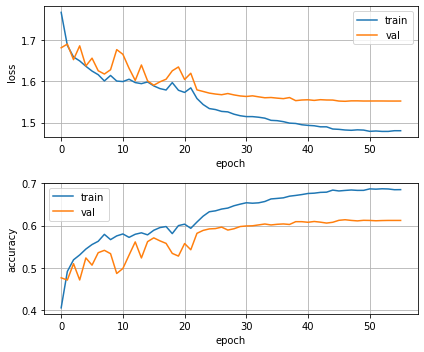

In [16]:
### Loss, Accuracy 시각화

plt.figure(figsize = (6,5))

# Loss
plt.subplot(211)
plt.plot(train_loss,label = "train")
plt.plot(val_loss,label = "val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()

# Accuracy
plt.subplot(212)
plt.plot(train_accuracy,label = "train")
plt.plot(val_accuracy,label = "val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()

plt.tight_layout()